In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Download data

tickers = {
    "SPY": "SPY",
    "EUR/USD": "EURUSD=X",
    "BTC": "BTC-USD"
}

data = {}
for name, ticker in tickers.items(): # items() returns a dict_items view object containing all key-value pairs in the form of tuples
    df = yf.download(ticker, start="2015-01-01", auto_adjust=False)
    data[name] = df["Adj Close"]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# Compute returns

returns = {}
log_returns = {}

for k, prices in data.items():
    returns[k] = prices.pct_change().dropna()
    log_returns[k] = np.log(prices / prices.shift(1)).dropna()
# The log of the simple gross return (1 + r_simple) is called the continuously compounded return or log return. 
# So, we have relationships: r_log = \ln(1+r_simple), r_simple = \exp(r_log) -1. 

In [4]:
# Compute the first 4 moments of the return series

from scipy.stats import skew, kurtosis

stats = {}

for k in returns: # looping over a dictionary takes on the value of each key in the dictionary; alternatively, we can use: for key in returns.keys()
    r = log_returns[k].to_numpy()
    stats[k] = {
        "Mean": r.mean(),
        "Volatility": r.std(),
        "Skewness": skew(r)[0], # the output of skew() is an array
        "Kurtosis": kurtosis(r, fisher=False)[0] 
        # fisher=False calculates the standard kurtosis (fourth central moment divided by the square of the variance); 
        # fisher=True calculates the excess kurtosis. 
    }

pd.DataFrame(stats).T

,Mean,Volatility,Skewness,Kurtosis
SPY,0.000504,0.011227,-0.583791,17.549908
EUR/USD,-0.000011,0.004976,0.019715,5.719226
BTC,0.001416,0.035436,-0.741499,14.999875


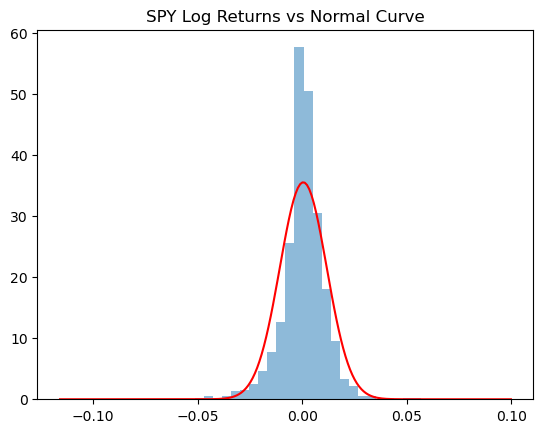

In [5]:
# Visualize non-normality

from scipy.stats import norm

r_1 = log_returns["SPY"] #.iloc[:, 0]

x = np.linspace(r_1.min(), r_1.max(), 200)
plt.hist(r_1, bins=50, density=True, alpha=0.5) # density=True means each bin will display the bin's raw count divided by the total number of counts and the bin widththe so that the area under the histogram integrates to 1 
plt.plot(x, norm.pdf(x, r_1.mean(), r_1.std()), "r")
plt.title("SPY Log Returns vs Normal Curve")
plt.show()

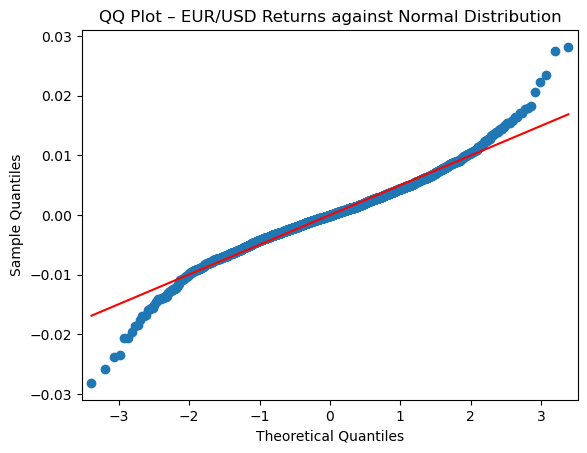

In [6]:
# Check tail deviation via Q-Q plot

import statsmodels.api as sm

r_2 = log_returns["EUR/USD"]

sm.qqplot(r_2.to_numpy().ravel(), line="s") # line='s' standardized line, the expected order statistics are scaled by the standard deviation of the given sample and have the mean added to them
plt.title("QQ Plot – EUR/USD Returns against Normal Distribution")
plt.show()

In [7]:
# Jarque–Bera test of whether the sample data has the skewness and kurtosis matching a normal distribution
# Note that this test only works for a large enough number of data samples (>2000).

from scipy.stats import jarque_bera

r_3 = log_returns["BTC"]

jb = jarque_bera(r_3) # returns the test statistic and the p-value for the normality hypothesis test

# The statistic combines sample skewness (S) and kurtosis (K) into a single JB statistic.
# It asymptotically follows a Chi-squared distribution with 2 degrees of freedom for large samples.
# Large JB statistic / small p-value (< 0.05): reject the null hypothesis, hence the data is likely not normal.
# Small JB statistic / large p-value (> 0.05): fail to reject the null hypothesis.

print("--- Jarque–Bera normality test of BTC returns ---")
print(f"JB statistic: {jb[0]:.2f}, p-value: {jb[1]:.6f}")
if jb[1] < 0.05:
    print(">> Null hypothesis rejected (returns are not normal)")
else:
    print(">> Fail to reject the null")

--- Jarque–Bera normality test of BTC returns ---
JB statistic: 24506.15, p-value: 0.000000
>> Null hypothesis rejected (returns are not normal)


In [8]:
# Ljung–Box test of autocorrelation

from statsmodels.stats.diagnostic import acorr_ljungbox

lb = acorr_ljungbox(r_1, lags=[20], return_df=True) 
# lags is the maximum lag that is included in the test; so in this example the null hypothesis is \rho_1 = \dots = \rho_20 = 0, where \rho_l is the lag-l autocorrelation between the return series.
# return_df indicates whether to return the result as a single DataFrame with columns max lag, lb_stat, lb_pvalue, where lb_stat is the Ljung-Box test statistic, lb_pvalue the p-value based on chi-square distribution.

lb_st = lb['lb_stat'].iloc[0]
lb_p = lb['lb_pvalue'].iloc[0]

print("--- Ljung–Box test (lag 20) of SPY daily autocorrelation ---")
print(f"LB statistic: {lb_st:.2f}, p-value: {lb_p:.6f}")
if lb_p < 0.05:
    print(">> Null hypothesis (no autocorrelation up to lag 20) rejected")
else:
    print(">> Fail to reject the null")

--- Ljung–Box test (lag 20) of SPY daily autocorrelation ---
LB statistic: 245.11, p-value: 0.000000
>> Null hypothesis (no autocorrelation up to lag 20) rejected


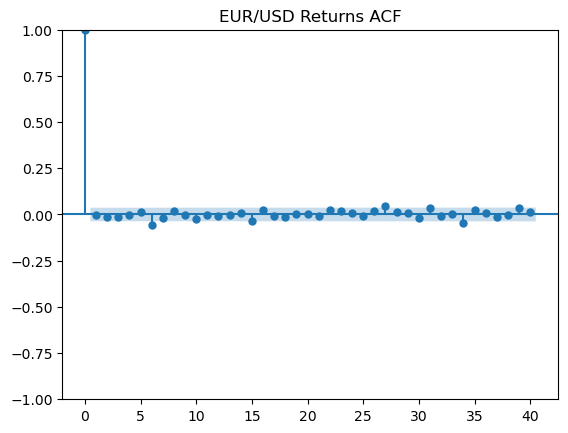

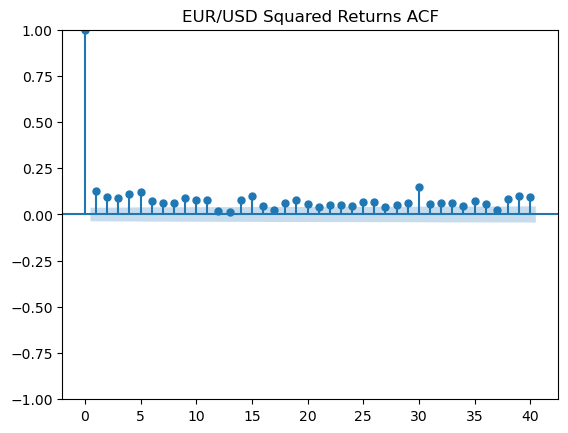

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(r_2, lags=40, alpha=0.05) # alpha=0.05 returns 95 % confidence intervals
plt.title("EUR/USD Returns ACF")
plt.show()

plot_acf(r_2**2, lags=40, alpha=0.05)
plt.title("EUR/USD Squared Returns ACF") # the squared return ACF is 
plt.show()

# Significant serial correlations for the squared returns suggests patterns in volatility clustering "large changes tend to be followed by large changes".

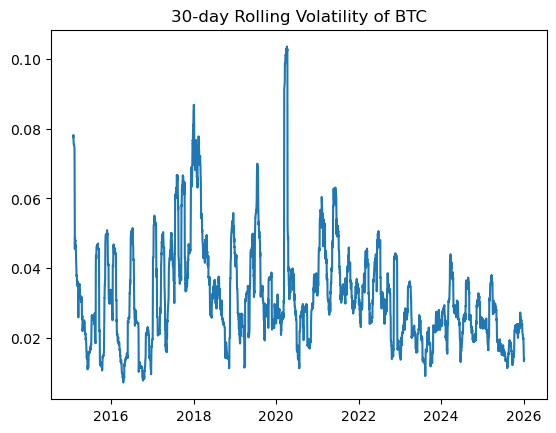

In [10]:
# Rolling volatility 

rolling_vol = r_3.rolling(30).std()

plt.plot(rolling_vol)
plt.title("30-day Rolling Volatility of BTC")
plt.show()
